In [ ]:
from typing import Union, List, Dict, Tuple, Callable
import functools
import operator
from matplotlib import pyplot as plt

import numpy as np
from numpy.linalg import norm
import sympy.stats
import networkx as nx

In [ ]:
def flatten(a):
    return functools.reduce(operator.iconcat, a, [])


GSym = Union[sympy.Symbol, sympy.stats.rv.RandomSymbol]

class Component:
    def __init__(self, I: List[str], O: str, f: str):
        self.I = I
        self.O = O
        self.f = f

class System:
    def __init__(self, cs: List[Component]):
        assert len(set([c.O for c in cs])) == len(cs)
        self.cs = cs

    def induced_scm(self, state_order: List[str] = None):
        V = set([c.O for c in self.cs])
        all = set(flatten([c.I for c in self.cs]))
        U = set(all) - set(V)
        return SCM(U, V, self.cs, state_order)

class SCM:
    def __init__(self, U: List[str], V: List[str], cs: List[Component], state_order: List[str] = None):
        self.U = U
        self.V = V
        self.cs_dict = {c.O: c for c in cs}
        self.dag = nx.DiGraph()
        self.dag.add_nodes_from(self.U)
        self.dag.add_nodes_from(self.V)
        for c in cs:
            self.dag.add_edges_from([(x,c.O) for x in c.I])
        tp_sort = list(nx.topological_sort(self.dag))
        # self.context_order = [x for x in tp_sort if x in U]
        if state_order is None:
            self.state_order = [x for x in tp_sort if x in V]
        else:
            self.state_order = state_order

    def get_state(self, _context: Dict[GSym, float]):
        _ret_dict, _ret_list = {}, []
        _subs = _context
        for _u in _context.keys():
            locals()[_u] = sympy.symbols(_u)
        for _v in self.state_order:
            _v_sym = eval(self.cs_dict[_v].f)
            locals()[_v] = _v_sym
            _v_val = float(_v_sym.evalf(subs=_subs))
            _ret_dict[_v] = _v_val
            _ret_list.append(_v_val)
            _subs[_v] = _v_val
        return _ret_dict, np.array(_ret_list)

In [ ]:
def liability_shares(cs_spec: List[Component], cs: List[Component], context: Dict[GSym, float]):
    s_aeb_spec = System(cs_spec)
    scm_aeb_spec = s_aeb_spec.induced_scm()
    spec_st_dict, spec_st_list = scm_aeb_spec.get_state(context)

    shares = np.zeros(len(cs))
    for i in range(len(cs)):
        cs_rep = list(cs_spec)
        cs_rep[i] = cs[i]
        s_aeb_rep = System(cs_rep)
        scm_aeb_rep = s_aeb_rep.induced_scm(state_order=scm_aeb_spec.state_order)
        st_dict, st_list = scm_aeb_rep.get_state(context)
        shares[i] = norm(st_list - spec_st_list)
    shares = shares/sum(shares)
    return shares


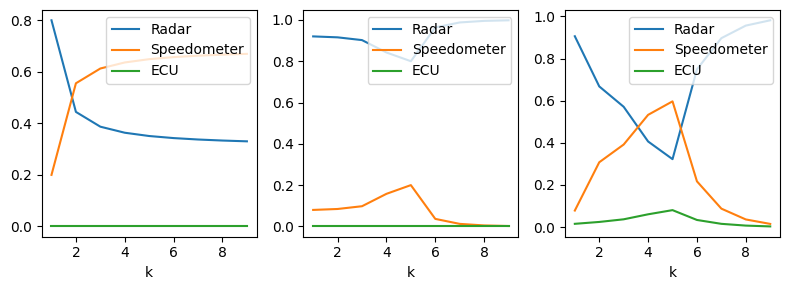

In [ ]:
if __name__ == '__main__':
    d, e_ra, v, e_sm = sympy.symbols('d e_ra v e_sm')
    context = {'d': 80, 'e_ra': 20, 'v': 40, 'e_sm': -5}

    c_ra_spec = Component(['d'], 'D', 'd')
    c_sm_spec = Component(['v'], 'V', 'v')
    c_ecu_spec = Component(['V', 'D'], 'B', 'V/D')
    cs_spec = [c_ra_spec, c_sm_spec, c_ecu_spec]

    xs = list(range(1, 10))
    ys = np.zeros((3, len(xs), len(cs_spec)))
    for ki, k in enumerate(xs):
        c_ra1 = Component(['d', 'e_ra'], 'D', f'd + e_ra')
        c_sm3 = Component(['v', 'e_sm'], 'V', f'v/{k} + e_sm')
        cs1 = [c_ra1, c_sm3, c_ecu_spec]

        c_ra2 = Component(['d', 'e_ra'], 'D', f'd**{k/5} + e_ra')
        c_ra3 = Component(['d', 'e_ra'], 'D', f'd + e_ra')
        c_sm1 = Component(['v', 'e_sm'], 'V', f'v + e_sm')
        c_sm2 = Component(['v', 'e_sm'], 'V', f'v*{k} + e_sm')

        c_sm4 = Component(['v', 'e_sm'], 'V', f'v-3*{k} + e_sm')
        c_ecu1 = Component(['V', 'D'], 'B', f'V/D')
        c_ecu2 = Component(['V', 'D'], 'B', f'V/D-{k}')
        cs1 = [c_ra1, c_sm3, c_ecu_spec]
        cs2 = [c_ra2, c_sm1, c_ecu_spec]
        cs3 = [c_ra2, c_sm3, c_ecu2]
        shares1 = liability_shares(cs_spec, cs1, context)
        shares2 = liability_shares(cs_spec, cs2, context)
        shares3 = liability_shares(cs_spec, cs3, context)
        ys[0, ki] = shares1
        ys[1, ki] = shares2
        ys[2, ki] = shares3

    fig, axes = plt.subplots(1, 3, figsize=(8, 3))
    for axi,ax in enumerate(axes):
      ax.plot(xs, ys[axi])
      ax.set_xlabel('k')
      ax.legend(['Radar', 'Speedometer', 'ECU'], loc='upper right')
    fig.tight_layout()
    fig.show()